In [1]:
# install basic packages needed
import os
import pandas as pd
import numpy as np

# import packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import necessary packages for xgboost
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import minmax_scale, OneHotEncoder

#from xgboost import plot_tree
from sklearn import tree
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from scipy import stats
from scipy.stats import spearmanr

#### Please note that aim of notebook is to showcase working competency in building ML classification
- Models used: Regression (to cater to more "traditional" medical analytics folk) and XGBoost (for efficiency)
- Walk through commentary of notebook focused on documenting rationale
    - Feature engineering,
    - Model evauation, and 
    - Hyperparameter tuning 

- Synopsis: after evaluating and tuning both models, we see that the "simpler" Logistic regression performs better for this classification task. Some commentary as to the reasons why are also put forth.

In [2]:
# Step 1: Defining the problem
## Create a predictive model for CVD

# Step 2: Collect and Pre-process data
# URL contains "cleaned" dataset @ https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [3]:
# Read in data
heart_df = pd.read_csv('processed.cleveland.data', sep=",", header=None)
heart_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [4]:
# naming the columns
heart_df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
                   'oldpeak', 'slope', 'ca', 'thal', 'num']
#num is the predicted attribute

In [5]:
heart_df['hasCVD'] = 1
heart_df.loc[heart_df['num'] == 0, 'hasCVD'] = 0

In [6]:
heart_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hasCVD
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1,1


In [7]:
heart_df['hasCVD'].value_counts() # quite balanced outcomes!

0    164
1    139
Name: hasCVD, dtype: int64

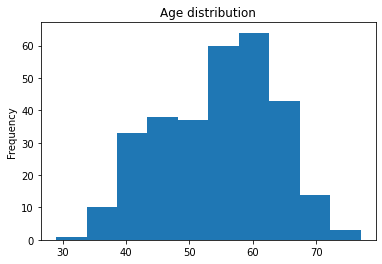

In [8]:
# Step 3: Explore the data
# visualise to see if we should use minmax or standard scalar, based on how "normal" data is

heart_df['age'].plot(kind = 'hist', bins = 10, title = 'Age distribution');

In [9]:
heart_df['sex'].value_counts() # more males than females

1.0    206
0.0     97
Name: sex, dtype: int64

In [10]:
heart_df['cp'].value_counts() # mostly asymptomatic

# Value 1: typical angina
# Value 2: atypical angina
# Value 3: non-anginal pain
# Value 4: asymptomatic 

4.0    144
3.0     86
2.0     50
1.0     23
Name: cp, dtype: int64

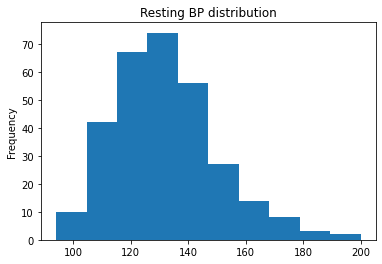

In [11]:
heart_df['trestbps'].plot(kind = 'hist', bins = 10, title = 'Resting BP distribution');

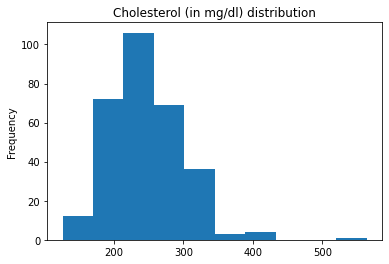

In [12]:
heart_df['chol'].plot(kind = 'hist', bins = 10, title = 'Cholesterol (in mg/dl) distribution');

In [13]:
heart_df['fbs'].value_counts() # mostly OK

0.0    258
1.0     45
Name: fbs, dtype: int64

In [14]:
heart_df['restecg'].value_counts()

# Value 0: normal
# Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
# Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria (possible HBP?)

0.0    151
2.0    148
1.0      4
Name: restecg, dtype: int64

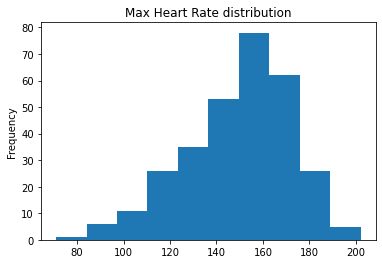

In [15]:
heart_df['thalach'].plot(kind = 'hist', bins = 10, title = 'Max Heart Rate distribution');

In [16]:
heart_df['exang'].value_counts()
# Exercised Induced Angina
# Value 1 = Yes
# Value 2 = No

0.0    204
1.0     99
Name: exang, dtype: int64

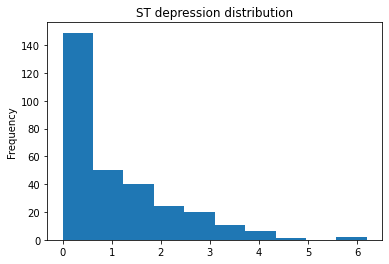

In [17]:
heart_df['oldpeak'].plot(kind = 'hist', bins = 10, title = 'ST depression distribution');

# oldpeak = ST depression induced by exercise relative to rest 

In [18]:
heart_df['slope'].value_counts()

# slope: the slope of the peak exercise ST segment
# Value 1: upsloping
# Value 2: flat
# Value 3: downsloping 

1.0    142
2.0    140
3.0     21
Name: slope, dtype: int64

In [19]:
heart_df['ca'].value_counts()
# number of major vessels (0-3) colored by flourosopy 

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

In [20]:
heart_df.loc[heart_df['ca'] == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hasCVD
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0,0


In [21]:
heart_df['thal'].value_counts()
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64

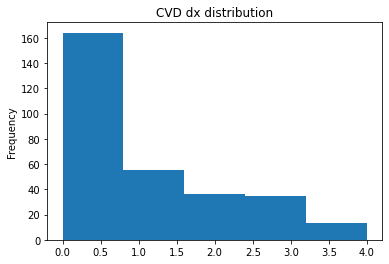

In [22]:
heart_df['num'].plot(kind = 'hist', bins = 5, title = 'CVD dx distribution');

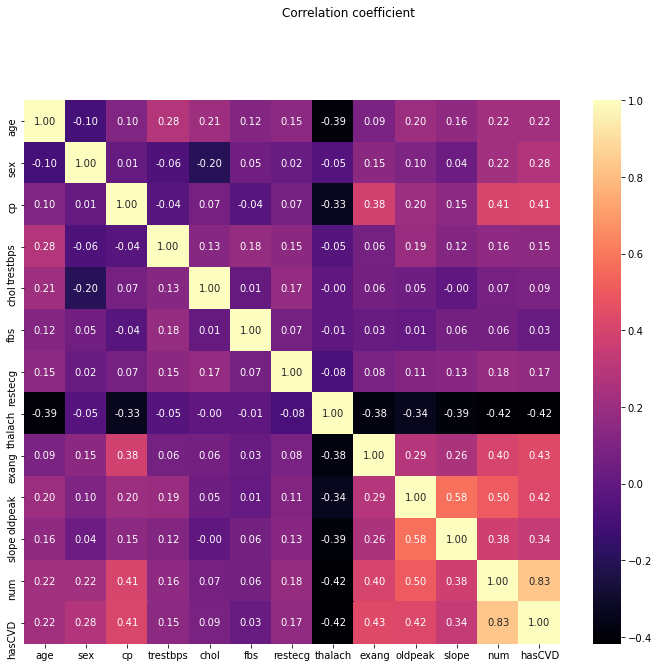

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(heart_df.corr(),annot=True,cmap="magma",fmt='.2f')
plt.suptitle('Correlation coefficient', y = 1.01);

In [24]:
# Step 4: feature engineering
## maybe add BMI (weight and height), cholesterol ratio (hdl and chol)
## 1) age bands for age variable
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
heart_df['age_band'] = pd.cut(heart_df['age'], bins=bins, labels=labels)

In [25]:
# One-hot encode age bands
age_onehot = pd.get_dummies(heart_df['age_band'], prefix='age')

# Combine with original dataframe
heart_df = pd.concat([heart_df, age_onehot], axis=1)

In [26]:
# create CP description to differentiate types of chest pain

heart_df['cp_desc'] = 'no_chest_pain'
heart_df.loc[heart_df['cp'] == 1, 'cp_desc'] = 'typical_angina'
heart_df.loc[heart_df['cp'] == 2, 'cp_desc'] = 'atypical_angina'
heart_df.loc[heart_df['cp'] == 3, 'cp_desc'] = 'non_anginal_pain'

In [27]:
# One-hot encode CP (chest pain) 
cpdesc_onehot = pd.get_dummies(heart_df['cp_desc'], prefix='cp')
heart_df = pd.concat([heart_df, cpdesc_onehot], axis=1)

In [28]:
# create gender dummy
heart_df['is_male'] = 0
heart_df.loc[heart_df['sex'] ==1, 'is_male'] = 1

In [29]:
# creating categorical variable for trestbps
## 90 and below = hypotension
## 120 and below = normal
## above 120 = hypertension

bins = [0, 90, 120, 100000]
labels = ['hypotension', 'normal', 'hypertension']
heart_df['BP_range'] = pd.cut(heart_df['trestbps'], bins=bins, labels=labels)

In [30]:
heart_df['BP_range'].value_counts()

hypertension    206
normal           97
hypotension       0
Name: BP_range, dtype: int64

In [31]:
# One-hot encode BP_range
bprange_onehot = pd.get_dummies(heart_df['BP_range'], prefix='bp')
heart_df = pd.concat([heart_df, bprange_onehot], axis=1)

In [32]:
# create categorical variable for chol; serem / total chelesterol
## less than 200; normal
## 200 to 239; borderline high
## 240; high

bins = [0, 200, 240, 100000]
labels = ['normal', 'boderline_high', 'high']
heart_df['serum_chol_range'] = pd.cut(heart_df['chol'], bins=bins, labels=labels)

In [33]:
heart_df['serum_chol_range'].value_counts()

high              152
boderline_high    101
normal             50
Name: serum_chol_range, dtype: int64

In [34]:
serum_oneshot = pd.get_dummies(heart_df['serum_chol_range'], prefix='chol')
heart_df = pd.concat([heart_df, serum_oneshot], axis=1)

In [35]:
# create fbs dummy
heart_df['is_high_fbs'] = 0
heart_df.loc[heart_df['fbs'] ==1, 'is_high_fbs'] = 1

In [36]:
print(heart_df['is_high_fbs'].value_counts())
print(heart_df['fbs'].value_counts())

0    258
1     45
Name: is_high_fbs, dtype: int64
0.0    258
1.0     45
Name: fbs, dtype: int64


In [37]:
# Value 0: normal
# Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
# Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria (possible HBP?)

# create dummy for resting ecg; dx of LVH (left ventricular hypertrophy) or not?
heart_df['is_lvh_dx'] = 1
heart_df.loc[heart_df['restecg'] == 0, 'is_lvh_dx'] = 0

In [38]:
print(heart_df['is_lvh_dx'].value_counts())
print(heart_df['restecg'].value_counts())

1    152
0    151
Name: is_lvh_dx, dtype: int64
0.0    151
2.0    148
1.0      4
Name: restecg, dtype: int64


In [39]:
# create variable to maximum target heart rate for moderate physical activity; 76%
# source: https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm
heart_df['76pp_heartrate'] = 0.76 * (220 - heart_df['age'])

In [40]:
# create dummy for resting ecg; dx of LVH (left ventricular hypertrophy) or not?
heart_df['is_overexert_heartrate'] = 0
heart_df.loc[heart_df['76pp_heartrate'] > heart_df['thalach'], 'is_overexert_heartrate'] = 1

In [41]:
heart_df['is_overexert_heartrate'].value_counts()

0    254
1     49
Name: is_overexert_heartrate, dtype: int64

<Figure size 864x864 with 0 Axes>

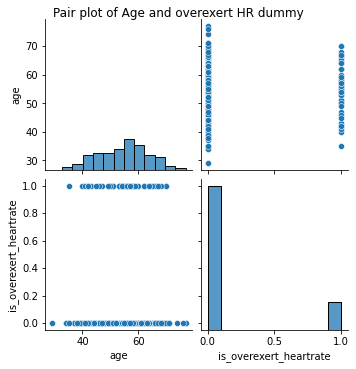

In [42]:
plt.figure(figsize=(12,12))
ax = sns.pairplot(heart_df, vars = ['age', 'is_overexert_heartrate'])

plt.suptitle('Pair plot of Age and overexert HR dummy', y = 1.01);

# data shows quite a good spread of ages for individuals that seem to have overexerted

In [43]:
# Exercised Induced Angina
# Value 1 = Yes
# Value 2 = No

# create dummy for exerise induced angina / chest pain
heart_df['is_exercise_cp'] = 1
heart_df.loc[heart_df['exang'] == 0, 'is_exercise_cp'] = 0

In [44]:
print(heart_df['exang'].value_counts())
print(heart_df['is_exercise_cp'].value_counts())

0.0    204
1.0     99
Name: exang, dtype: int64
0    204
1     99
Name: is_exercise_cp, dtype: int64


In [45]:
# use oldpeak as-is

In [46]:
#slope - creating a new st_slope_desc variable to description
heart_df['st_slope_desc'] = ''
heart_df.loc[heart_df['slope'] == 3, 'st_slope_desc'] = 'downsloping'
heart_df.loc[heart_df['slope'] == 2, 'st_slope_desc'] = 'flat'
heart_df.loc[heart_df['slope'] == 1, 'st_slope_desc'] = 'upsloping'

In [47]:
print(heart_df['slope'].value_counts())
print(heart_df['st_slope_desc'].value_counts())

1.0    142
2.0    140
3.0     21
Name: slope, dtype: int64
upsloping      142
flat           140
downsloping     21
Name: st_slope_desc, dtype: int64


In [48]:
# One-hot encode BP_range
slope_onehot = pd.get_dummies(heart_df['st_slope_desc'], prefix='st_slope')
heart_df = pd.concat([heart_df, slope_onehot], axis=1)

In [49]:
# clean up CA
heart_df['maj_vessels_coloured'] = 0
heart_df.loc[heart_df['ca'] == '1.0', 'maj_vessels_coloured'] = 1
heart_df.loc[heart_df['ca'] == '2.0', 'maj_vessels_coloured'] = 2
heart_df.loc[heart_df['ca'] == '3.0', 'maj_vessels_coloured'] = 3

In [50]:
print(heart_df['ca'].value_counts())
print(heart_df['maj_vessels_coloured'].value_counts())

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64
0    180
1     65
2     38
3     20
Name: maj_vessels_coloured, dtype: int64


In [51]:
# create thal desc and then one-hot
heart_df['thalassemia_type'] = 'normal'
heart_df.loc[heart_df['thal'] == '6.0', 'thalassemia_type'] = 'fixed defect'
heart_df.loc[heart_df['thal'] == '7.0', 'thalassemia_type'] ='reversable defect'

In [52]:
print(heart_df['thal'].value_counts())
print(heart_df['thalassemia_type'].value_counts())

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64
normal               168
reversable defect    117
fixed defect          18
Name: thalassemia_type, dtype: int64


In [53]:
# One-hot encode thal
thal_onehot = pd.get_dummies(heart_df['thalassemia_type'], prefix='thal')
heart_df = pd.concat([heart_df, thal_onehot], axis=1)

In [54]:
#heart_df.dtypes
list(heart_df)

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'num',
 'hasCVD',
 'age_band',
 'age_0-20',
 'age_20-30',
 'age_30-40',
 'age_40-50',
 'age_50-60',
 'age_60-70',
 'age_70-80',
 'age_80-90',
 'cp_desc',
 'cp_atypical_angina',
 'cp_no_chest_pain',
 'cp_non_anginal_pain',
 'cp_typical_angina',
 'is_male',
 'BP_range',
 'bp_hypotension',
 'bp_normal',
 'bp_hypertension',
 'serum_chol_range',
 'chol_normal',
 'chol_boderline_high',
 'chol_high',
 'is_high_fbs',
 'is_lvh_dx',
 '76pp_heartrate',
 'is_overexert_heartrate',
 'is_exercise_cp',
 'st_slope_desc',
 'st_slope_downsloping',
 'st_slope_flat',
 'st_slope_upsloping',
 'maj_vessels_coloured',
 'thalassemia_type',
 'thal_fixed defect',
 'thal_normal',
 'thal_reversable defect']

In [55]:
# create dataframe for model building by dropping variables
model_df = heart_df[[ 'hasCVD',
                     'oldpeak',
                     'age_0-20',
                     'age_20-30',
                     'age_30-40',
                     'age_40-50',
                     'age_50-60',
                     'age_60-70',
                     'age_70-80',
                     'age_80-90',
                     'cp_atypical_angina',
                     'cp_no_chest_pain',
                     'cp_non_anginal_pain',
                     'cp_typical_angina',
                     'is_male',
                     # 'bp_hypotension', turn this one off because there are NO values in this category
                     'bp_normal',
                     'bp_hypertension',
                     'chol_normal',
                     'chol_boderline_high',
                     'chol_high',
                     'is_high_fbs',
                     'is_lvh_dx',
                     'is_overexert_heartrate',
                     'is_exercise_cp',
                     'st_slope_downsloping',
                     'st_slope_flat',
                     'st_slope_upsloping',
                     'maj_vessels_coloured',
                     'thal_fixed defect',
                     'thal_normal',
                     'thal_reversable defect']]

In [56]:
model_df.head()

,hasCVD,oldpeak,age_0-20,age_20-30,age_30-40,age_40-50,age_50-60,age_60-70,age_70-80,age_80-90,...,is_lvh_dx,is_overexert_heartrate,is_exercise_cp,st_slope_downsloping,st_slope_flat,st_slope_upsloping,maj_vessels_coloured,thal_fixed defect,thal_normal,thal_reversable defect
0,0,2.3,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,1,1.5,0,0,0,0,0,1,0,0,...,1,1,1,0,1,0,3,0,1,0
2,1,2.6,0,0,0,0,0,1,0,0,...,1,0,1,0,1,0,2,0,0,1
3,0,3.5,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,1.4,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In [57]:
# Step 5: create training test split, 
# note to use min max scalar later as variables are NOT normally distributed
X = model_df.loc[:, model_df.columns != 'hasCVD']
X.head()

,oldpeak,age_0-20,age_20-30,age_30-40,age_40-50,age_50-60,age_60-70,age_70-80,age_80-90,cp_atypical_angina,...,is_lvh_dx,is_overexert_heartrate,is_exercise_cp,st_slope_downsloping,st_slope_flat,st_slope_upsloping,maj_vessels_coloured,thal_fixed defect,thal_normal,thal_reversable defect
0,2.3,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,1.5,0,0,0,0,0,1,0,0,0,...,1,1,1,0,1,0,3,0,1,0
2,2.6,0,0,0,0,0,1,0,0,0,...,1,0,1,0,1,0,2,0,0,1
3,3.5,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.4,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,1,0


In [58]:
y = model_df['hasCVD']
y.head()

0    0
1    1
2    1
3    0
4    0
Name: hasCVD, dtype: int64

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [60]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(212, 30)
(91, 30)
(212,)
(91,)


In [61]:
X_train_scale = minmax_scale(X_train)
X_test_scale = minmax_scale(X_test)

In [62]:
# Step 6a: Initiate XGBoost model

model = xgboost.XGBClassifier(use_label_encoder = False, eval_metric = 'auc', random_state = 1)
model.fit(X_train_scale, y_train)

print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [63]:
# Step 7a / 8a: Traiing and initial evaluation
y_pred_prob = model.predict_proba(X_test_scale)
y_pred = model.predict(X_test_scale)
AUC = roc_auc_score(y_test, y_pred_prob[:,1])
print("AUC of test model: %.4f" % AUC)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data: %.2f%%" % (accuracy * 100.0))

y_pred_train = model.predict(X_train_scale)
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy on train data: %.2f%%" % (accuracy * 100.0))
# appears to be some evidence of overfitting

AUC of test model: 0.8746
Accuracy on test data: 76.92%
Accuracy on train data: 99.53%


In [64]:
# Step 9a: Perform hyperparameter optimisation using RandomisedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# parameters to tune
params = {
 'learning_rate' : [0.01, 0.1, 0.2, 0.4, 0.5],
 'max_depth' : [2, 4, 5, 6, 8],
 'min_child_weight' : [ 1, 2, 3, 4, 5],
 'gamma': [ 0.0, 0.01, 0.02 , 0.1, 0.2 ],
 'colsample_bytree' : [0.1, 0.25, 0.5, 0.75 , 1]
}

rs_model = RandomizedSearchCV(model,
                              param_distributions=params,
                              n_iter=5,scoring='roc_auc', n_jobs=-1,cv=5,verbose=3, random_state=1)


In [65]:
#model fitting
rs_model.fit(X,y)

#parameters selected
rs_model.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 0.02,
 'colsample_bytree': 0.25}

In [66]:
# based on the above, we pass the optimised parameters into an improved model and re-evaluate

model_tuned = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.25, eval_metric='auc',
              gamma=0.02, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1,
              max_delta_step=0, max_depth=4, min_child_weight=1, 
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

AUC: 0.9388
K-fold CV average score: 0.7976
Accuracy on test data: 85.71%
Accuracy on train data: 94.81%


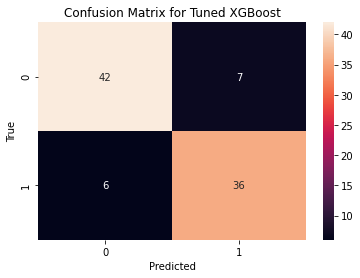

In [67]:
# Evaluation post hyperparameter tuning, performing cross validation using K-fold CV
model_tuned.fit(X_train_scale, y_train)
y_pred_prob_tuned = model_tuned.predict_proba(X_test_scale)
y_pred_tuned = model_tuned.predict(X_test_scale)
AUC = roc_auc_score(y_test, y_pred_prob_tuned[:,1])
print("AUC: %.4f" % AUC)

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
kf_cv_scores = cross_val_score(model_tuned, X_train_scale, y_train, cv=kfold )
print("K-fold CV average score: %.4f" % kf_cv_scores.mean())

# assessing predictions
accuracy = accuracy_score(y_test, y_pred_tuned)
print("Accuracy on test data: %.2f%%" % (accuracy * 100.0))

y_pred_train = model_tuned.predict(X_train_scale)
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy on train data: %.2f%%" % (accuracy * 100.0))

# showing confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot = True)
plt.title('Confusion Matrix for Tuned XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True');



              precision    recall  f1-score   support

           0     0.8750    0.8571    0.8660        49
           1     0.8372    0.8571    0.8471        42

    accuracy                         0.8571        91
   macro avg     0.8561    0.8571    0.8565        91
weighted avg     0.8576    0.8571    0.8572        91



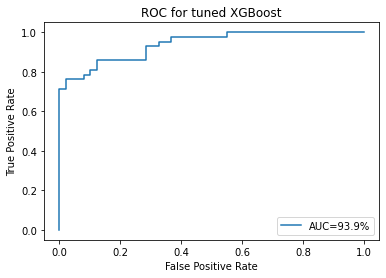

In [68]:
print(classification_report(y_test, y_pred_tuned, digits = 4))
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_tuned[:,1])

#create ROC curve
plt.plot(fpr, tpr, label="AUC=%.1f%%" % (AUC*100))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC for tuned XGBoost')
plt.show();

In [69]:
# Step 6b: Initiate Logistic Regression Model
logr = LogisticRegression(random_state=1)

In [70]:
# fit the model with data
logr.fit(X_train_scale, y_train.values.ravel())

y_pred_logr = logr.predict(X_test_scale)

In [71]:
# Step 7b and 8b: Training and initial evaluation
y_pred_prob = logr.predict_proba(X_test_scale)
y_pred = logr.predict(X_test_scale)
AUC = roc_auc_score(y_test, y_pred_prob[:,1])
print("AUC of test model: %.4f" % AUC)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data: %.2f%%" % (accuracy * 100.0))

y_pred_train = logr.predict(X_train_scale)
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy on train data: %.2f%%" % (accuracy * 100.0))
# even without tuning, logistic regression appears to function better than XGBoost!

AUC of test model: 0.9320
Accuracy on test data: 86.81%
Accuracy on train data: 84.91%


In [72]:
# visualise confusion matrix
cm_logr = confusion_matrix(y_test, y_pred_logr)
cm_logr

array([[43,  6],
       [ 6, 36]])

In [73]:
# Step 9b: perform hyperparameter tuning; focused on regularisation (lasso, ridge) for purposes of explainability
from sklearn.model_selection import GridSearchCV

# parameters of interest
params = {
 'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'C' : np.logspace(-4, 4, 20),
 'max_iter': [ 100, 1000, 2500, 5000], 
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

best_logr = GridSearchCV(logr,
                              param_grid=params,
                              scoring='roc_auc', n_jobs=-1,cv=5,verbose=1)

In [74]:
#model fitting
best_logr.fit(X,y)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


/Users/joelloh/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.5        ...        nan 0.89641028 0.89770898]
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 1000, 2500, 5000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc', verbose=1)

In [75]:
#parameters selected
best_logr.best_params_

{'C': 0.23357214690901212, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

In [76]:
# GridSearch results in a L1 (lasso) regularised model with relatively small lambda
logr_regularised = LogisticRegression(penalty = 'l1', C = 0.23357214690901212, max_iter = 1000,
                                      solver = 'saga', random_state=1)

In [77]:
# fit the model with data
logr_regularised.fit(X_train, y_train.values.ravel())

y_pred_logr_regularised = logr_regularised.predict(X_test)

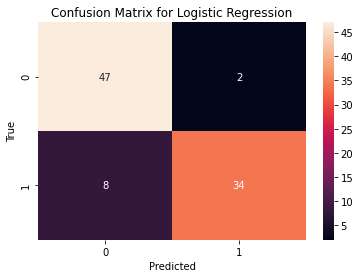

In [78]:
# showing confusion matrix
cm_logr_regularised = confusion_matrix(y_test, y_pred_logr_regularised)
sns.heatmap(cm_logr_regularised, annot = True)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True');

In [79]:
y_pred_proba_regularised = logr_regularised.predict_proba(X_test)[::,1]
AUC_regularised = roc_auc_score(y_test, y_pred_proba_regularised)
print("AUC of logistic regression: %.4f" % AUC_regularised)

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
kf_cv_scores = cross_val_score(logr_regularised, X_train, y_train.values.ravel(), cv=kfold )
print("K-fold CV average score: %.4f" % kf_cv_scores.mean())

accuracy = accuracy_score(y_test, y_pred_logr_regularised)
print("Accuracy of logistic regression: %.2f%%" % (accuracy * 100.0))

AUC of logistic regression: 0.9286
K-fold CV average score: 0.8069
Accuracy of logistic regression: 89.01%


              precision    recall  f1-score   support

           0     0.8545    0.9592    0.9038        49
           1     0.9444    0.8095    0.8718        42

    accuracy                         0.8901        91
   macro avg     0.8995    0.8844    0.8878        91
weighted avg     0.8960    0.8901    0.8891        91



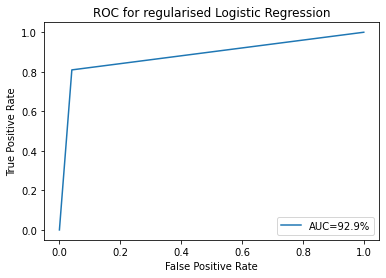

In [80]:
print(classification_report(y_test, y_pred_logr_regularised, digits = 4))

fpr, tpr, _ = roc_curve(y_test,  y_pred_logr_regularised)

#create ROC curve
plt.plot(fpr, tpr, label="AUC=%.1f%%" % (AUC_regularised*100))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC for regularised Logistic Regression')
plt.show();


              precision    recall  f1-score   support

           0     0.8750    0.8571    0.8660        49
           1     0.8372    0.8571    0.8471        42

    accuracy                         0.8571        91
   macro avg     0.8561    0.8571    0.8565        91
weighted avg     0.8576    0.8571    0.8572        91



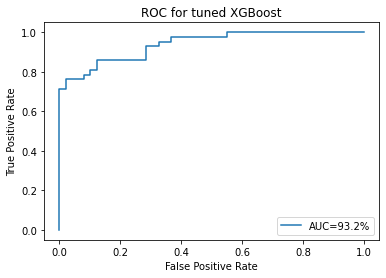

In [81]:
# showing XGBoost
print(classification_report(y_test, y_pred_tuned, digits = 4))
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_tuned[:,1])

#create ROC curve
plt.plot(fpr, tpr, label="AUC=%.1f%%" % (AUC*100))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC for tuned XGBoost')
plt.show();

## Concluding Remarks
### XGBoost vs Logistic Regression Model

- Accuracy of Logistic Regression Model higher (even before regularisation / tuning) viz XGBoost, post tuning!
    - Even without regularisation, Logistic Regression has an accuracy of 86.81% (XGBoost was 85.71% after tuning)
    - Gap widens post regularisation, with Logistic Regression accuracy increasing to 89.01%
- AUC decreases (similiar AUC values for Logistic Model before regularisation with XGBoost) after regularisation
    - This is somewhat expected due to GridSearch recommending rather strict regularisation, via a small lambda
    - Seems to have been what caused the lowered AUC as the regularisation forces the model to not overfit
        - Implicit assumption here is that even after tuning, the XGBoost model was still overfitted
        - This is rather plausible as XGBoost has a tendency to converge quickly
            - This is *not* always a good thing in medical classification problems
- Note that for this analysis, I am not considering F-score
    - This is because dataset is fairly balanced